In [17]:
import numpy
from matplotlib import pyplot
%matplotlib inline
from unsteady_helper import *
import steady_helper as steady

#### import NACA 0012 geometry

In [18]:
x, y = numpy.loadtxt('resources/naca0012.dat', dtype=float, delimiter='\t', unpack=True)

#### generate panels

In [19]:
N = 40
panels= gen_panels(x, y, N)

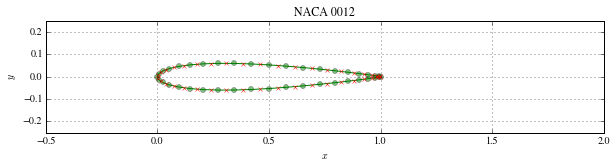

In [20]:
plot_panels(panels, 'NACA 0012')

#### define freestream

In [21]:
u_inf, alpha = 1.0, 0.0    # alpha in deg
freestream = Freestream(u_inf, alpha)

#### Neumann Boundary Condition

We evaluate the velocity potential at the center point of each panel at the $k$-th time step.

$$
\begin{align*}
\phi\left(x_{c_i},y_{c_i}\right) &= V_\infty x_{c_i} \cos \alpha + V_\infty y_{c_i} \sin \alpha \\
&+ \sum_{j=1}^N \frac{\sigma_j}{2\pi} \int_j \ln \left(\sqrt{(x_{c_i}-x_j(s_j))^2+(y_{c_i}-y_j(s_j))^2} \right) {\rm d}s_j \\
&- \sum_{j=1}^N \frac{\gamma}{2\pi} \int_j \tan^{-1} \left(\frac{y_{c_i}-y_j(s_j)}{x_{c_i}-x_j(s_j)}\right) {\rm d}s_j \\
&- \sum_{t=1}^k \frac{\gamma_{w_t}}{2\pi} \tan^{-1} \left(\frac{y_{c_i}-y_{w_t}}{x_{c_i}-x_{w_t}}\right)
\end{align*}
$$

$$0 = \underline{V}\cdot\underline{n}_i = \frac{\partial}{\partial n_i} \left\{ \phi\left(x_{c_i},y_{c_i}\right) \right\}$$

$$
\begin{align*}
0 &= V_\infty \cos \left(\alpha-\beta_i\right) + \frac{\sigma_i}{2} \\
&+ \sum_{j=1,j\neq i}^N \frac{\sigma_j}{2\pi} \int_j \frac{\partial}{\partial n_i} \ln \left(\sqrt{(x_{c_i}-x_j(s_j))^2+(y_{c_i}-y_j(s_j))^2} \right) {\rm d}s_j \\
&- \sum_{j=1,j\neq i}^N \frac{\gamma}{2\pi} \int_j \frac{\partial}{\partial n_i} \tan^{-1} \left(\frac{y_{c_i}-y_j(s_j)}{x_{c_i}-x_j(s_j)}\right) {\rm d}s_j \\
&- \sum_{t=1}^k \frac{\gamma_{w_t}}{2\pi} \frac{\partial}{\partial n_i} \tan^{-1} \left(\frac{y_{c_i}-y_{w_t}}{x_{c_i}-x_{w_t}}\right)
\end{align*}
$$

$$
\frac{\partial}{\partial n_i} \ln \left(\sqrt{(x_{c_i}-x_j(s_j))^2+(y_{c_i}-y_j(s_j))^2} \right) = \frac{\left(x_{c_i}-x_j\right)\frac{\partial x_{c_i}}{\partial n_i} + \left(y_{c_i}-y_j\right)\frac{\partial y_{c_i}}{\partial n_i}}{\left(x_{c_i}-x_j\right)^2 + \left(x_{c_i}-x_j\right)^2}
$$

$$
\frac{\partial}{\partial n_i} \tan^{-1} \left(\frac{y_{c_i}-y_j(s_j)}{x_{c_i}-x_j(s_j)}\right)= \frac{\left(x_{c_i}-x_j\right)\frac{\partial y_{c_i}}{\partial n_i} - \left(y_{c_i}-y_j\right)\frac{\partial x_{c_i}}{\partial n_i}}{\left(x_{c_i}-x_j\right)^2 + \left(y_{c_i}-y_j\right)^2}
$$

$$
\frac{\partial x_{c_i}}{\partial n_i} = \cos \beta_i  \hspace{10mm} \frac{\partial y_{c_i}}{\partial n_i} = \sin \beta_i
$$

Rearrange the equation by putting the unknowns $\left( \sigma_1, \sigma_2, ..., \sigma_N, \gamma, \gamma_{w_k} \right)$ on LHS, known terms $(V_{\infty}, \gamma_{w_1}, \gamma_{w_2}, ..., \gamma_{w_{k-1}})$ on RHS:

$$
\begin{align}
\frac{\sigma_i}{2} + \sum_{j=1,j\neq i}^N \frac{\sigma_j}{2\pi} \int_j \frac{\left(x_{c_i}-x_j\right)\frac{\partial x_{c_i}}{\partial n_i} + \left(y_{c_i}-y_j\right)\frac{\partial y_{c_i}}{\partial n_i}}{\left(x_{c_i}-x_j\right)^2 + \left(x_{c_i}-x_j\right)^2} {\rm d}s_j \\
- \gamma \sum_{j=1,j\neq i}^N \frac{1}{2\pi} \int_j \frac{\left(x_{c_i}-x_j\right)\frac{\partial y_{c_i}}{\partial n_i} - \left(y_{c_i}-y_j\right)\frac{\partial x_{c_i}}{\partial n_i}}{\left(x_{c_i}-x_j\right)^2 + \left(y_{c_i}-y_j\right)^2} {\rm d}s_j \\
- \frac{\gamma_{w_k}}{2\pi} \frac{\left(x_{c_i}-x_{w_k}\right)\frac{\partial y_{c_i}}{\partial n_i} - \left(y_{c_i}-y_{w_k}\right)\frac{\partial x_{c_i}}{\partial n_i}}{\left(x_{c_i}-x_{w_k}\right)^2 + \left(y_{c_i}-y_{w_k}\right)^2} \\
= - V_\infty \cos \left(\alpha-\beta_i\right) + \sum_{t=1}^{k-1} \frac{\gamma_{w_t}}{2\pi} \frac{\left(x_{c_i}-x_{w_t}\right)\frac{\partial y_{c_i}}{\partial n_i} - \left(y_{c_i}-y_{w_t}\right)\frac{\partial x_{c_i}}{\partial n_i}}{\left(x_{c_i}-x_{w_t}\right)^2 + \left(y_{c_i}-y_{w_t}\right)^2}
\end{align}
$$

The equation set contains $N$ equations, and $N+2$ unknowns. Write it out in matrix forms: 

\begin{equation}
\left[ \begin{array}{ccc}
A_{source} & A_{vortex} & A_{new-wake} 
\end{array} \right]
\begin{bmatrix}
\sigma_1 \\
\sigma_2 \\
\vdots \\
\sigma_n \\
\gamma \\
\gamma_{w_k}
\end{bmatrix}
= 
\begin{bmatrix}
b_{freestream} + b_{old-wake} \\
\end{bmatrix}
\end{equation}

where $A_{source}$ matrix is of size $N \times N$, $A_{vortex}$ and $A_{new-wake}$ are arrays of size $N \times 1$, $b_{freestream}$ and $b_{old-wake}$ also have a size $N \times 1$.

The source matrix remains the same as the steady source panel method, so we can reuse the code to generate the source matrix $A_{source}$:

In [22]:
def source_matrix(panels):
    """Builds the source matrix.
    
    Arguments
    ---------
    panels -- array of panels.
    
    Returns
    -------
    A -- NxN matrix (N is the number of panels).
    """
    A = numpy.empty((panels.size, panels.size), dtype=float)
    numpy.fill_diagonal(A, 0.5)
    
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i,j] = 0.5/numpy.pi*integral(p_i.xc, p_i.yc, p_j, numpy.cos(p_i.beta), numpy.sin(p_i.beta))
    
    return A

In [23]:
def vortex_array(panels):
    """Builds the vortex array.
    
    Arguments
    ---------
    panels - array of panels.
    
    Returns
    -------
    a -- 1D array (Nx1, N is the number of panels).
    """
    a = numpy.zeros(panels.size, dtype=float)
    
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                a[i] -= 0.5/numpy.pi*integral(p_i.xc, p_i.yc, 
                                             p_j, 
                                             numpy.sin(p_i.beta), -numpy.cos(p_i.beta))
    return a

In [38]:
def new_wake_array(panels, new_wake):
    a = numpy.zeros(panels.size, dtype=float)
    
    for i, p_i in enumerate(panels):
        a[i] = -0.5/numpy.pi*((p_i.xc-new_wake.x)*numpy.sin(p_i.beta) - (p_i.yc-new_wake.y)*numpy.cos(p_i.beta))  \
               / ((p_i.xc-new_wake.x)**2 + (p_i.yc-new_wake.y)**2)
    return a

In [40]:
def rhs_freestream(panels, freestream):
    b = numpy.zeros(panels.size, dtype=float)
    
    for i, p_i in enumerate(panels):
        b[i] = -freestream.u_inf*numpy.cos(freestream.alpha-p_i.beta)
    
    return b

In [44]:
def rhs_wakes(panels, wakes):
    b = numpy.zeros(panels.size, dtype=float)
    
    for i, p_i in enumerate(panels):
        for wake in wakes:
            b[i] += wake.gamma/(2*numpy.pi) * ((p_i.xc-wake.x)*numpy.sin(p_i.beta) - (p_i.yc-wake.y)*numpy.cos(p_i.beta))  \
               / ((p_i.xc-wake.x)**2 + (p_i.yc-wake.y)**2)
    return b

#### unsteady 'Kutta-condition'

$$
V_{t_1} = - \left( V_{t_N} + \frac{\gamma_t}{V_{kutta}\Delta t} \right)
$$

$$
\begin{align*}
V_{t_i} &= V_\infty \sin \left(\alpha-\beta_i\right) \\
&+ \sum_{j=1,j\neq i}^N \frac{\sigma_j}{2\pi} \int_j \frac{\left(x_{c_i}-x_j\right)\frac{\partial x_{c_i}}{\partial t_i} + \left(y_{c_i}-y_j\right)\frac{\partial y_{c_i}}{\partial t_i}}{\left(x_{c_i}-x_j\right)^2 + \left(x_{c_i}-x_j\right)^2} {\rm d}s_j \\
&- \sum_{j=1,j\neq i}^N \frac{\gamma}{2\pi} \int_j \frac{\left(x_{c_i}-x_j\right)\frac{\partial y_{c_i}}{\partial t_i} - \left(y_{c_i}-y_j\right)\frac{\partial x_{c_i}}{\partial t_i}}{\left(x_{c_i}-x_j\right)^2 + \left(x_{c_i}-x_j\right)^2} {\rm d}s_j -\frac{\gamma}{2} \\
& - \sum_{t=1}
\end{align*}
$$

$$
\begin{align*}
0 &= V_\infty \cos \left(\alpha-\beta_i\right) + \frac{\sigma_i}{2} \\
&+ \sum_{j=1,j\neq i}^N \frac{\sigma_j}{2\pi} \int_j \frac{\partial}{\partial n_i} \ln \left(\sqrt{(x_{c_i}-x_j(s_j))^2+(y_{c_i}-y_j(s_j))^2} \right) {\rm d}s_j \\
&- \sum_{j=1,j\neq i}^N \frac{\gamma}{2\pi} \int_j \frac{\partial}{\partial n_i} \tan^{-1} \left(\frac{y_{c_i}-y_j(s_j)}{x_{c_i}-x_j(s_j)}\right) {\rm d}s_j \\
&- \sum_{t=1}^k \frac{\gamma_{w_t}}{2\pi} \frac{\partial}{\partial n_i} \tan^{-1} \left(\frac{y_{c_i}-y_{w_t}}{x_{c_i}-x_{w_t}}\right)
\end{align*}
$$

$$\frac{\partial x_{c_i}}{\partial t_i} = -\sin \beta_i \hspace{10mm} \frac{\partial y_{c_i}}{\partial t_i} = \cos \beta_i$$

In [1]:
def kutta_array(panels):
    return 0

#### run steady code to initialize the unsteady

In [25]:
# run steady code to initialize
solution = steady.solve(panels, freestream)

for i, panel in enumerate(panels):
    panel.sigma = solution[i]

gamma = solution[-1]

In [26]:
# calculates the accuracy
accuracy = sum([panel.sigma*panel.length for panel in panels])
print '--> sum of source/sink strengths:', accuracy

--> sum of source/sink strengths: 0.00461703117528


In [27]:
def vel_Kutta(panels):
    v_x = 0.5*(panels[0].vt*(-numpy.sin(panels[0].beta)) \
            + panels[-1].vt*(-numpy.sin(panels[-1].beta)))
    v_y = 0.5*(panels[0].vt*(numpy.cos(panels[0].beta)) \
            + panels[-1].vt*(numpy.cos(panels[-1].beta)))
    return v_x, v_y

In [37]:
class Wake():
    def __init__(self):
        self.x = 0.
        self.y = 0.
        self.gamma = 0.
    
    def location(self, panels, c, dt):
        # calculate the velocity of shedding vortex
        v_x, v_y = vel_Kutta(panels)
        # calculate the position of shedding vortex
        self.x = panels[0].xa + v_x*c*dt
        self.y = panels[0].ya + v_y*c*dt

In [39]:
wakes = []

#### Kelvin condition

$$ \frac{\partial \Gamma}{\partial t} = 0
$$

$$ c_p = 1 - \frac{V^2}{V_{\infty}^2} - \frac{2}{V_{\infty}^2} \frac{\partial \phi}{\partial t}
$$

In [28]:
%%javascript
IPython.load_extensions('IPython-notebook-extensions-3.x/usability/codefolding/main');

<IPython.core.display.Javascript object>